# 1. The One-vs-All Kernel Perceptron

## Libraries

In [93]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import time
from tqdm import tqdm
from tabulate import tabulate

from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import euclidean_distances

## Import Data

In [63]:
#import the dataset
df = pd.read_csv('zipcombo.csv')
df.head()

,label,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0


In [157]:
#split the data into features X and target y
X = df[df.columns[1:]].values.copy()
y = df['label'].values.copy()

## Kernel Functions

In [65]:
#function to perform mapping with the polynomial kernel
def polynomial(X_i, X_j, d):
    '''
    d: dimension fo the polynomial kernel
    '''
    K = ( X_i.dot(X_j.T) ) ** d
    return K

#a fast implementaion of the polynomial kernel
def fast_polynomial(X_i, X_j, d):
    '''
    d: dimension fo the polynomial kernel
    '''
    K = polynomial_kernel(X_i, Y=X_j, degree=d)
    return K 

#function to perform mapping with the gaussian kernel
def gaussian(X_i, X_j, c):
    '''
    c: width of the gaussian kernel
    '''
    m, n = len(X_i), len(X_j)
    K = np.zeros((m,n))            #initialize the mapped feature matrix
    for i in range(m):
        for j in range(n):
            K[i][j] = np.exp( -c * np.linalg.norm(X_i[i]-X_j[j]) ** 2 )
    return K

#a faster implementation of the gaussian kernel
def fast_gaussian(X_i, X_j, c):
    '''
    c: width of the gaussian kernel
    '''
    K = euclidean_distances(X_i, X_j)
    K = np.exp( -c * K ** 2 )
    return K

## Train-Test Split Functions

In [272]:
def shuffle_data(X, y, seed=None):
    if seed:                         #set a random seed for reproducable results
        np.random.seed(seed)
    idx = np.arange(len(X))          
    np.random.shuffle(idx)           #shuffle the index
    return X[idx], y[idx]

#function to perform train-test split
def train_test_split(X, y, train_split, shuffle, seed=None):
    '''
    train_split: percentage of data for training
    '''
    if shuffle:                                     #shuffle the data if needed
        X, y = shuffle_data(X, y, seed)
    n_train = int(train_split*len(X))               #find the split location
    X_train, X_test = X[:n_train], X[n_train:]      
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, X_test, y_train, y_test

#function to split data for k-fold cross-validation
def KFold(X, y, k):
    m = len(X)
    n_split = int(m/k)         
    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = [], [], [], []
    for fold in range(1, k+1):
        X_valid = X[(fold-1)*n_split:fold*n_split]
        y_valid = y[(fold-1)*n_split:fold*n_split]
        X_train = np.append(X[0:(fold-1)*n_split], X[fold*n_split:], axis=0)
        y_train = np.append(y[0:(fold-1)*n_split], y[fold*n_split:], axis=0)
        X_train_fold.append(X_train)
        X_valid_fold.append(X_valid)
        y_train_fold.append(y_train)
        y_valid_fold.append(y_valid)
    return X_train_fold, X_valid_fold, y_train_fold, y_valid_fold

## One-vs-All Kernel Perceptron

<div>
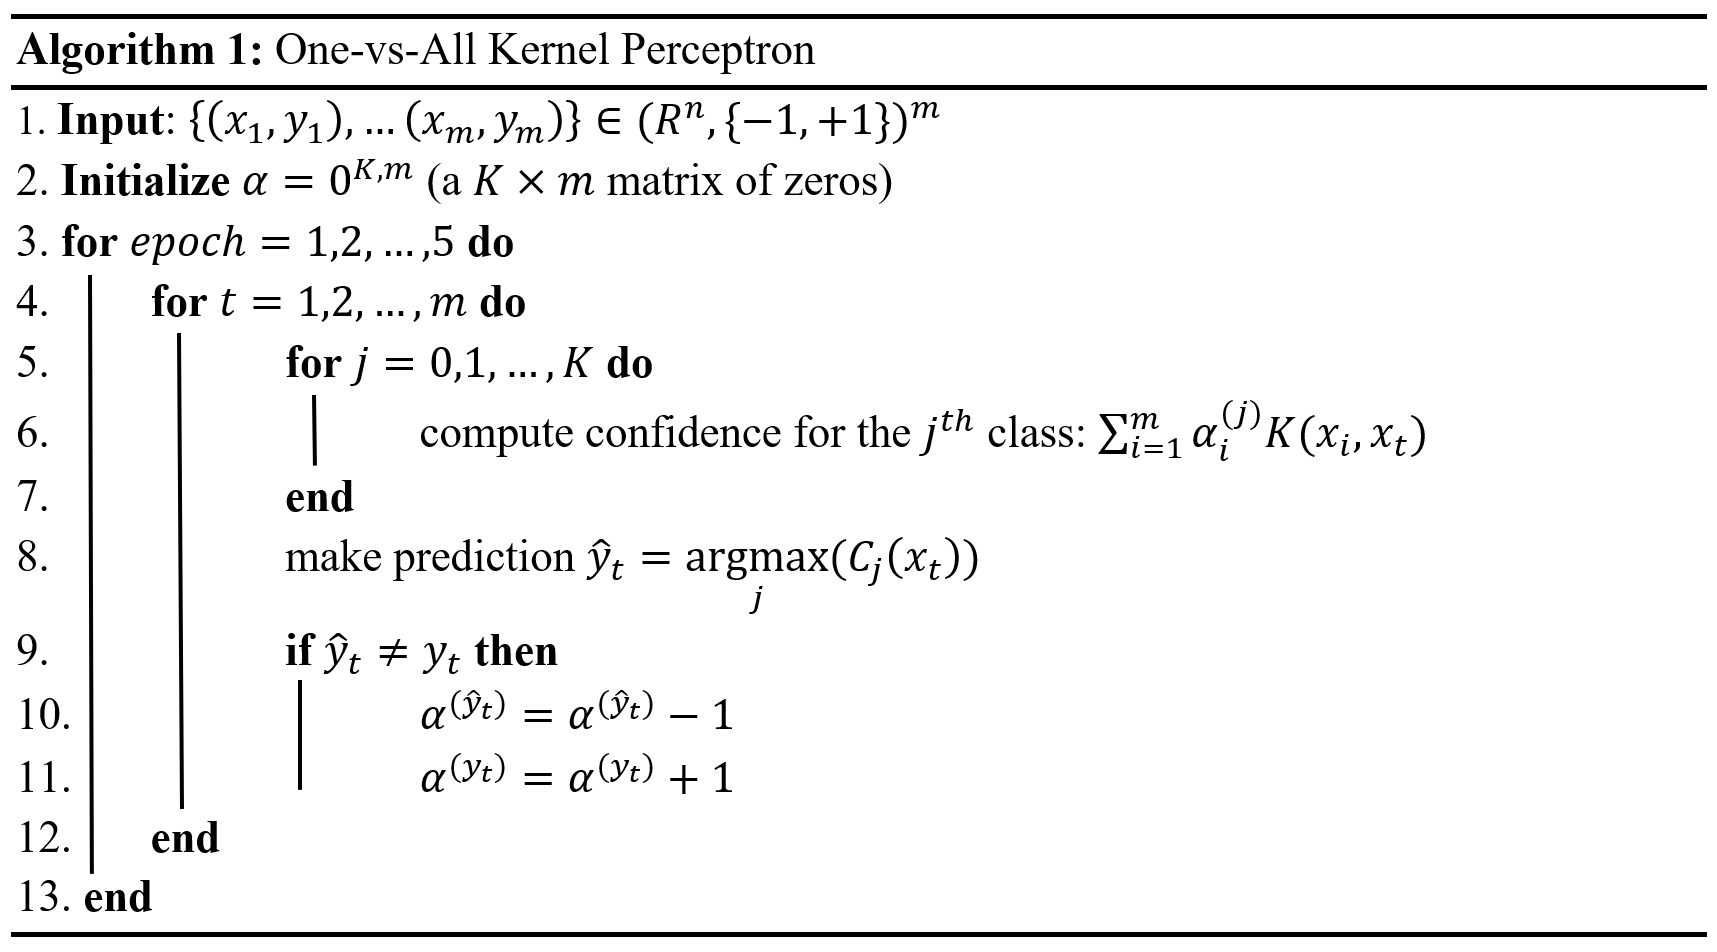
</div>

In [155]:
class MultiKernelPerceptron(object):
    
    def __init__(self, X_train, y_train, X_test, y_test, kernel, kernel_param, epochs):
        
        #initialize the datasets
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        #initialize the sizes
        self.epochs = epochs
        self.batch_size = len(self.y_train)  
        self.test_size = len(self.y_test)
        self.classes = np.unique(np.append(self.y_train, self.y_test))
        self.n_c = len(self.classes)
        
        #initialize the kernel method
        self.kernel = kernel
        self.kernel_param = kernel_param
        
        #initialize the mapped data with kernelization
        if kernel == 'p':
            self.K = fast_polynomial(self.X_train, self.X_train, self.kernel_param)
            self.K_test = fast_polynomial(self.X_test, self.X_train, self.kernel_param)
        if kernel =='g':
            self.K = fast_gaussian(self.X_train, self.X_train, self.kernel_param)
            self.K_test = fast_gaussian(self.X_test, self.X_train, self.kernel_param)   
        
        #initialize the alpha matrix: n_c × m
        self.alpha = np.zeros(shape=(self.n_c, self.batch_size))
        
        #intialize the confidence matrices: m × n_c
        self.confidence = np.zeros(shape=(self.batch_size, self.n_c))
        self.confidence_test = np.zeros(shape=(self.batch_size, self.n_c))
        
        #initialize the confusion matrix: n_c × n_c
        self.confusion = np.zeros(shape=(self.n_c, self.n_c))
        

    def predict(self, i, data):
        if data == 'train':
            confidence = np.dot(self.alpha, self.K[i])             #compute the confidence
            self.confidence[i,:] = confidence                      #store the results in the condifence matrix
            y_pred = np.argmax(confidence)                         #make the final prediction
        elif data == 'test':
            confidence = np.dot(self.alpha, self.K_test[i])
            self.confidence_test[i,:] = confidence
            y_pred = np.argmax(confidence)
        return confidence, y_pred
        
    
    def train(self):
        for _ in range(self.epochs):                    #train the algorithm over 10 epoches
            errors = 0                                  #reset the count of mistakes to 0 at the beginning of each epoch
            for i in range(self.batch_size):            #sequentially train the algorithm over each sample
                confidence, y_pred = self.predict(i, 'train')      #make prediction
                label = int(self.y_train[i])
                if int(y_pred) != label:                           #if the prediction does not match the label
                    errors += 1                                    #increase the count of mistakes by 1
                    self.alpha[label, i] += 1                      #update the alpha 
                    self.alpha[y_pred, i] -= 1
            error_rate = (errors/self.batch_size) * 100            #compute the error rate for this epoch
        return error_rate                                          #return the training error rate on the last epoch
    
    
    def test(self):
        errors = 0
        for i in range(self.test_size):
            confidence, y_pred = self.predict(i, 'test') 
            label = int(self.y_test[i])
            if int(y_pred) != label:
                errors += 1
                self.confusion[label, int(y_pred)] += 1       #update the copnfusion matrix 
        for i in range(self.n_c):                             #for each class
            count = list(self.y_test).count(i)                      #count the number of class i in the test set
            self.confusion[i] = self.confusion[i] / count     #compute the error rates
        error_rate = (errors/self.test_size) * 100 
        return error_rate 

## Basic Results

In [104]:
#initialization
np.random.seed(0)
train_split = 0.8
d_list = np.arange(1,8)
train_error, train_std, test_error, test_std = [], [], [], []

for d in d_list:               #for different dimensions of the polynomial kernel
    single_run_train_errors, single_run_test_errors = [], []
    for run in tqdm(range(20)):      #perform 20 runs
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, shuffle=True)     #randomly split the data
        clf = MultiKernelPerceptron(X_train, y_train, X_test, y_test, kernel='p', kernel_param=d, epochs=5)
        train_e = clf.train()                            #compute the training error on the 80% data
        single_run_train_errors.append(train_e)
        test_e = clf.test()                              #compute the test error on the 20% data
        single_run_test_errors.append(test_e) 
    train_error.append(np.mean(single_run_train_errors))
    train_std.append(np.std(single_run_train_errors))
    test_error.append(np.mean(single_run_test_errors))
    test_std.append(np.std(single_run_test_errors))
    print('Polynomial order: ', d, ', mean train error: ', train_error[-1], ', mean test error: ', test_error[-1])

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  1 , mean train error:  9.023931164291476 , mean test error:  9.631720430107526


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  2 , mean train error:  4.768082817961817 , mean test error:  6.908602150537634


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  3 , mean train error:  2.5746168324818504 , mean test error:  4.92741935483871


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  4 , mean train error:  1.6509814466254369 , mean test error:  4.752688172043011


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  5 , mean train error:  1.1118580263511697 , mean test error:  4.048387096774194


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  6 , mean train error:  0.8120462489916644 , mean test error:  3.7876344086021505


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.74s/it]

Polynomial order:  7 , mean train error:  0.6460069911266471 , mean test error:  3.561827956989247


In [114]:
#tabulate the results
data = []
for i in range(len(d_list)):
    train_result = f"{'{:.4f}'.format(train_error[i])}±{'{:.4f}'.format(train_std[i])}"
    test_result = f"{'{:.4f}'.format(test_error[i])}±{'{:.4f}'.format(test_std[i])}"
    result = [int(d_list[i]), train_result, test_result]
    data.append(result)
print(tabulate(data, 
               headers = ["d", "Mean Train Error Rates (%)", "Mean Test Error Rates (%)"], 
               tablefmt = "simple_outline",
               stralign = "center"))

┌─────┬──────────────────────────────┬─────────────────────────────┐
│   d │  Mean Train Error Rates (%)  │  Mean Test Error Rates (%)  │
├─────┼──────────────────────────────┼─────────────────────────────┤
│   1 │        9.0239±0.2944         │        9.6317±1.8428        │
│   2 │        4.7681±0.2877         │        6.9086±1.5810        │
│   3 │        2.5746±0.1838         │        4.9274±0.6437        │
│   4 │        1.6510±0.1692         │        4.7527±0.7367        │
│   5 │        1.1119±0.1261         │        4.0484±0.6295        │
│   6 │        0.8120±0.1401         │        3.7876±0.6084        │
│   7 │        0.6460±0.1170         │        3.5618±0.4026        │
└─────┴──────────────────────────────┴─────────────────────────────┘


## Cross-Validation

In [135]:
#initialization 
np.random.seed(1)
train_split = 0.8
d_stars, test_errors = [], []

for run in tqdm(range(20)):          #perform 20 runs
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, shuffle=True)     #randomly split the data
    d_star, best_error = 0, float('inf')            #initialize the best d and best error
    for d in d_list:           #try different dimensions of the polynomial kernel
        valid_errors = []      #initialize a list to store validation errors
        X_train_frold, X_valid_fold, y_train_fold, y_valid_fold = KFold(X_train, y_train, 5)    #split the training set into 5 folds
        for Xtrain, Xvalid, ytrain, yvalid in zip(X_train_frold, X_valid_fold, y_train_fold, y_valid_fold):
            clf = MultiKernelPerceptron(Xtrain, ytrain, Xvalid, yvalid, kernel='p', kernel_param=d, epochs=5)
            train_error = clf.train()               #train the classifier
            valid_errors.append(clf.test())         #evalaute the classifier on the validation set
        if np.mean(valid_errors) < best_error:      #if the current d value gives a lower error rate
            best_error = np.mean(valid_errors)      #update the best error so far
            d_star = d                              #update the best d value so far
    #retrain the classifier on the entire training set with the best d value
    clf = MultiKernelPerceptron(X_train, y_train, X_test, y_test, kernel='p', kernel_param=d_star, epochs=5)   
    train_error = clf.train()
    test_error = clf.test()
    test_errors.append(test_error)
    d_stars.append(d_star)
    print('d*: ', d_star, ', test error rate: ', test_errors[-1])

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [43:28<00:00, 130.43s/it]


In [146]:
#tabulate the results
data = []
for i in range(20):
    test_result = f"{'{:.4f}'.format(test_errors[i])}"
    result = [int(i+1), d_stars[i], test_result]
    data.append(result)
print(tabulate(data, 
               headers = ["run", "d*", "Test Error Rates (%)"], 
               tablefmt = "simple_outline",
               numalign = "center"))

┌───────┬──────┬─────────────────────────────┐
│  run  │  d*  │  Mean Test Error Rates (%)  │
├───────┼──────┼─────────────────────────────┤
│   1   │  5   │           3.3871            │
│   2   │  7   │           2.8495            │
│   3   │  7   │           3.2796            │
│   4   │  7   │           3.1183            │
│   5   │  7   │           3.4946            │
│   6   │  7   │            4.086            │
│   7   │  7   │           3.4946            │
│   8   │  5   │           3.4946            │
│   9   │  6   │           3.2258            │
│  10   │  7   │           3.4409            │
│  11   │  6   │           4.5161            │
│  12   │  7   │            4.086            │
│  13   │  6   │           3.6559            │
│  14   │  6   │           3.1183            │
│  15   │  6   │           4.3011            │
│  16   │  4   │           4.6237            │
│  17   │  6   │           3.3333            │
│  18   │  7   │           2.5806            │
│  19   │  4 

In [144]:
print('Mean d*: ', f"{'{:.1f}'.format(np.mean(d_stars))} ± {'{:.1f}'.format(np.std(d_stars))}")
print('Mean Test Error (%): ', f"{'{:.2f}'.format(np.mean(test_errors))} ± {'{:.2f}'.format(np.std(test_errors))}")

Mean d*:  6.2 ± 1.0
Mean Test Error (%):  3.55 ± 0.58


## Confusion Matrix

In [164]:
#intialization
np.random.seed(2)
train_split = 0.8
confusion_mats = []

for run in tqdm(range(20)):          #perform 20 runs
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, shuffle=True)     #randomly split the data
    d_star, best_error = 0, float('inf')            #initialize the best d and best error
    for d in d_list:           #try different dimensions of the polynomial kernel
        valid_errors = []      #initialize a list to store validation errors
        X_train_frold, X_valid_fold, y_train_fold, y_valid_fold = KFold(X_train, y_train, 5)    #split the training set into 5 folds
        for Xtrain, Xvalid, ytrain, yvalid in zip(X_train_frold, X_valid_fold, y_train_fold, y_valid_fold):
            clf = MultiKernelPerceptron(Xtrain, ytrain, Xvalid, yvalid, kernel='p', kernel_param=d, epochs=5)
            train_error = clf.train()               #train the classifier
            valid_errors.append(clf.test())         #evalaute the classifier on the validation set
        if np.mean(valid_errors) < best_error:      #if the current d value gives a lower error rate
            best_error = np.mean(valid_errors)      #update the best error so far
            d_star = d                              #update the best d value so far
    #retrain the classifier on the entire training set with the best d value
    clf = MultiKernelPerceptron(X_train, y_train, X_test, y_test, kernel='p', kernel_param=d_star, epochs=5)   
    train_error = clf.train()
    test_error = clf.test()
    confusion_mat  = clf.confusion    #obtain the confusion matrix
    confusion_mats.append(confusion_mat)
    print('Run: ', int(run), ', Confusion Matrix: \n', str(confusion_mat))

  5%|████                                                                              | 1/20 [02:33<48:39, 153.67s/it]

Run:  0 , Confusion Matrix: 
 [[0.         0.00347222 0.         0.         0.         0.01388889
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00980392 0.         0.01470588 0.         0.
  0.         0.01470588 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.00564972 0.00564972 0.        ]
 [0.00568182 0.01704545 0.01704545 0.         0.         0.02272727
  0.00568182 0.03977273 0.         0.02840909]
 [0.         0.         0.01351351 0.01351351 0.00675676 0.
  0.02027027 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00625    0.
  0.         0.         0.00625    0.01875   ]
 [0.         0.         0.01515152 0.0530303  0.         0.03030303
  0.         0.00757576 0.    

 10%|████████▏                                                                         | 2/20 [04:49<42:55, 143.06s/it]

Run:  1 , Confusion Matrix: 
 [[0.         0.         0.         0.         0.00330033 0.00330033
  0.         0.         0.         0.00330033]
 [0.         0.         0.         0.         0.00369004 0.
  0.00369004 0.         0.         0.00369004]
 [0.         0.00502513 0.         0.         0.01507538 0.00502513
  0.01005025 0.00502513 0.         0.        ]
 [0.         0.         0.01775148 0.         0.         0.06508876
  0.         0.         0.0295858  0.        ]
 [0.         0.00645161 0.         0.         0.         0.00645161
  0.01290323 0.00645161 0.00645161 0.        ]
 [0.         0.         0.01428571 0.00714286 0.00714286 0.
  0.         0.         0.         0.        ]
 [0.00617284 0.         0.         0.         0.         0.00617284
  0.         0.         0.01234568 0.        ]
 [0.         0.         0.00666667 0.         0.         0.
  0.         0.         0.         0.00666667]
 [0.         0.         0.         0.         0.         0.0397351
  0.   

 15%|████████████▎                                                                     | 3/20 [06:42<36:42, 129.56s/it]

Run:  2 , Confusion Matrix: 
 [[0.         0.         0.         0.00307692 0.00307692 0.00307692
  0.         0.         0.00307692 0.        ]
 [0.         0.         0.00408163 0.         0.00816327 0.
  0.         0.         0.         0.        ]
 [0.         0.01086957 0.         0.01086957 0.00543478 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.01176471 0.
  0.         0.01176471 0.02352941 0.00588235]
 [0.         0.         0.         0.         0.         0.00546448
  0.         0.         0.         0.00546448]
 [0.00735294 0.         0.00735294 0.03676471 0.01470588 0.
  0.00735294 0.         0.01470588 0.        ]
 [0.00636943 0.         0.         0.         0.01910828 0.00636943
  0.         0.         0.00636943 0.        ]
 [0.         0.         0.         0.         0.02097902 0.
  0.         0.         0.         0.01398601]
 [0.01360544 0.01360544 0.         0.00680272 0.01360544 0.00680272
  0.         0.       

 20%|████████████████▍                                                                 | 4/20 [08:24<31:39, 118.72s/it]

Run:  3 , Confusion Matrix: 
 [[0.         0.00320513 0.         0.00320513 0.         0.
  0.00320513 0.         0.00320513 0.00320513]
 [0.         0.         0.         0.         0.         0.
  0.004329   0.         0.         0.        ]
 [0.         0.         0.         0.01025641 0.01025641 0.00512821
  0.00512821 0.         0.02051282 0.00512821]
 [0.         0.         0.         0.         0.         0.01704545
  0.         0.         0.01704545 0.        ]
 [0.         0.04022989 0.         0.00574713 0.         0.
  0.01724138 0.01149425 0.         0.04597701]
 [0.00632911 0.00632911 0.         0.01265823 0.00632911 0.
  0.00632911 0.         0.         0.        ]
 [0.00613497 0.00613497 0.01226994 0.         0.00613497 0.
  0.         0.         0.01226994 0.        ]
 [0.         0.01369863 0.         0.         0.         0.
  0.         0.         0.01369863 0.07534247]
 [0.00724638 0.         0.         0.         0.00724638 0.
  0.         0.00724638 0.         0. 

 25%|████████████████████▌                                                             | 5/20 [10:05<28:04, 112.32s/it]

Run:  4 , Confusion Matrix: 
 [[0.         0.         0.         0.00983607 0.         0.
  0.00327869 0.         0.00655738 0.00327869]
 [0.         0.         0.         0.         0.00409836 0.
  0.00409836 0.         0.         0.        ]
 [0.         0.         0.         0.00505051 0.00505051 0.
  0.         0.         0.00505051 0.        ]
 [0.         0.         0.00606061 0.         0.         0.
  0.         0.01212121 0.01212121 0.        ]
 [0.00578035 0.01156069 0.         0.         0.         0.01156069
  0.00578035 0.00578035 0.00578035 0.04624277]
 [0.         0.         0.01282051 0.02564103 0.00641026 0.
  0.01923077 0.         0.05128205 0.00641026]
 [0.         0.         0.         0.         0.         0.00621118
  0.         0.         0.         0.        ]
 [0.         0.         0.00621118 0.         0.         0.00621118
  0.         0.         0.01863354 0.        ]
 [0.         0.00714286 0.         0.01428571 0.00714286 0.
  0.         0.         0.    

 30%|████████████████████████▌                                                         | 6/20 [11:45<25:11, 107.96s/it]

Run:  5 , Confusion Matrix: 
 [[0.         0.         0.         0.00347222 0.         0.
  0.00347222 0.         0.         0.        ]
 [0.         0.         0.         0.         0.01606426 0.
  0.00401606 0.00401606 0.         0.        ]
 [0.00546448 0.         0.         0.01092896 0.00546448 0.
  0.         0.01092896 0.01639344 0.00546448]
 [0.01183432 0.         0.         0.         0.         0.01183432
  0.         0.         0.         0.        ]
 [0.         0.00645161 0.00645161 0.         0.         0.
  0.         0.         0.         0.00645161]
 [0.02424242 0.         0.         0.02424242 0.         0.
  0.00606061 0.00606061 0.00606061 0.01818182]
 [0.01142857 0.00571429 0.00571429 0.         0.01142857 0.01142857
  0.         0.         0.00571429 0.        ]
 [0.         0.         0.00617284 0.01234568 0.         0.
  0.         0.         0.00617284 0.00617284]
 [0.         0.         0.00684932 0.01369863 0.01369863 0.
  0.         0.00684932 0.         0.0

 35%|████████████████████████████▋                                                     | 7/20 [13:26<22:55, 105.84s/it]

Run:  6 , Confusion Matrix: 
 [[0.         0.         0.0033557  0.00671141 0.0033557  0.01342282
  0.00671141 0.         0.         0.        ]
 [0.         0.         0.         0.         0.00384615 0.
  0.00384615 0.00384615 0.         0.        ]
 [0.         0.         0.         0.0201005  0.00502513 0.
  0.00502513 0.01507538 0.01005025 0.00502513]
 [0.         0.         0.01587302 0.         0.         0.01058201
  0.         0.00529101 0.01058201 0.        ]
 [0.         0.         0.00613497 0.         0.         0.02453988
  0.01840491 0.         0.         0.03067485]
 [0.015625   0.         0.0078125  0.         0.         0.
  0.0234375  0.         0.0078125  0.03125   ]
 [0.         0.00588235 0.00588235 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00649351 0.         0.01948052 0.
  0.         0.         0.         0.02597403]
 [0.         0.         0.         0.02173913 0.00724638 0.00724638
  0.         0.0072463

 40%|████████████████████████████████▊                                                 | 8/20 [15:08<20:52, 104.38s/it]

Run:  7 , Confusion Matrix: 
 [[0.         0.         0.         0.         0.00331126 0.00331126
  0.         0.         0.         0.00331126]
 [0.         0.         0.         0.         0.00806452 0.
  0.         0.         0.         0.        ]
 [0.00561798 0.         0.         0.00561798 0.01123596 0.00561798
  0.         0.01685393 0.00561798 0.        ]
 [0.         0.         0.00625    0.         0.         0.025
  0.         0.         0.00625    0.        ]
 [0.         0.         0.00571429 0.         0.         0.00571429
  0.         0.         0.         0.01142857]
 [0.         0.         0.         0.02919708 0.00729927 0.
  0.00729927 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00671141 0.
  0.         0.         0.00671141 0.02684564]
 [0.00625    0.         0.         0.0125     0.         0.0125
  0.         0.0125    

 45%|████████████████████████████████████▉                                             | 9/20 [16:49<18:56, 103.35s/it]

Run:  8 , Confusion Matrix: 
 [[0.         0.         0.0031746  0.0031746  0.         0.0031746
  0.0031746  0.         0.         0.0031746 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00409836 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.01176471 0.         0.         0.00588235
  0.         0.         0.         0.        ]
 [0.01183432 0.         0.01775148 0.         0.         0.
  0.01183432 0.         0.         0.        ]
 [0.00714286 0.         0.01428571 0.00714286 0.00714286 0.
  0.00714286 0.         0.00714286 0.        ]
 [0.         0.         0.02793296 0.         0.00558659 0.
  0.         0.         0.01117318 0.        ]
 [0.         0.         0.00653595 0.00653595 0.         0.
  0.         0.         0.00653595 0.01960784]
 [0.00645161 0.         0.02580645 0.01290323 0.00645161 0.00645161
  0.         0.01290323 0.     

 50%|████████████████████████████████████████▌                                        | 10/20 [18:30<17:08, 102.83s/it]

Run:  9 , Confusion Matrix: 
 [[0.         0.         0.         0.00326797 0.00326797 0.
  0.00326797 0.         0.         0.        ]
 [0.         0.         0.         0.         0.00396825 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.01086957 0.00543478 0.
  0.01086957 0.00543478 0.01630435 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.03144654 0.00628931]
 [0.         0.00584795 0.         0.         0.         0.
  0.         0.         0.         0.00584795]
 [0.         0.         0.01290323 0.03870968 0.         0.
  0.01935484 0.00645161 0.01935484 0.        ]
 [0.01197605 0.         0.00598802 0.00598802 0.         0.
  0.         0.         0.00598802 0.        ]
 [0.         0.         0.00621118 0.         0.         0.
  0.         0.         0.00621118 0.02484472]
 [0.00746269 0.         0.00746269 0.00746269 0.01492537 0.00746269
  0.         0.         0.         0.        ]

 55%|████████████████████████████████████████████▌                                    | 11/20 [20:11<15:18, 102.07s/it]

Run:  10 , Confusion Matrix: 
 [[0.         0.         0.00940439 0.0031348  0.         0.00940439
  0.00626959 0.         0.0031348  0.        ]
 [0.         0.         0.         0.         0.00396825 0.
  0.00396825 0.         0.         0.        ]
 [0.         0.         0.         0.         0.0049505  0.
  0.         0.0049505  0.00990099 0.        ]
 [0.         0.         0.01369863 0.         0.         0.00684932
  0.         0.01369863 0.00684932 0.        ]
 [0.         0.00621118 0.00621118 0.         0.         0.
  0.         0.00621118 0.         0.        ]
 [0.         0.         0.         0.01470588 0.00735294 0.
  0.01470588 0.         0.         0.        ]
 [0.         0.00595238 0.         0.         0.         0.01785714
  0.         0.         0.00595238 0.        ]
 [0.         0.         0.00571429 0.00571429 0.         0.
  0.         0.         0.         0.01714286]
 [0.00662252 0.00662252 0.00662252 0.00662252 0.00662252 0.01986755
  0.01324503 0.      

 60%|████████████████████████████████████████████████▌                                | 12/20 [21:52<13:35, 101.95s/it]

Run:  11 , Confusion Matrix: 
 [[0.         0.         0.00928793 0.00619195 0.         0.00309598
  0.00309598 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.00813008
  0.         0.         0.00406504 0.        ]
 [0.01604278 0.         0.         0.01069519 0.01069519 0.00534759
  0.         0.         0.01604278 0.        ]
 [0.00617284 0.         0.00617284 0.         0.         0.04320988
  0.         0.         0.01234568 0.        ]
 [0.         0.01142857 0.         0.         0.         0.
  0.01142857 0.         0.00571429 0.01142857]
 [0.01470588 0.         0.01470588 0.         0.         0.
  0.02205882 0.         0.         0.00735294]
 [0.00641026 0.         0.         0.         0.01923077 0.00641026
  0.         0.         0.         0.        ]
 [0.         0.00588235 0.00588235 0.         0.00588235 0.
  0.         0.         0.00588235 0.01176471]
 [0.00671141 0.         0.         0.03355705 0.00671141 0.02013423
  0. 

 65%|████████████████████████████████████████████████████▋                            | 13/20 [23:33<11:51, 101.62s/it]

Run:  12 , Confusion Matrix: 
 [[0.         0.         0.00303951 0.00607903 0.         0.00607903
  0.00607903 0.         0.         0.00303951]
 [0.         0.         0.         0.00395257 0.00395257 0.
  0.         0.00395257 0.         0.        ]
 [0.         0.         0.         0.00584795 0.01754386 0.01169591
  0.00584795 0.         0.00584795 0.        ]
 [0.         0.         0.0060241  0.         0.         0.03012048
  0.         0.0060241  0.01204819 0.        ]
 [0.         0.         0.0060241  0.         0.         0.0060241
  0.01807229 0.         0.         0.0060241 ]
 [0.00645161 0.         0.         0.         0.00645161 0.
  0.01290323 0.         0.         0.        ]
 [0.         0.00564972 0.         0.         0.00564972 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00625    0.00625
  0.         0.         0.0125     0.        ]
 [0.         0.         0.00806452 0.         0.         0.0483871
  0.      

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [25:14<10:08, 101.35s/it]

Run:  13 , Confusion Matrix: 
 [[0.         0.         0.00328947 0.01315789 0.00328947 0.00328947
  0.00657895 0.         0.         0.        ]
 [0.         0.         0.         0.00754717 0.00377358 0.
  0.00754717 0.00754717 0.         0.        ]
 [0.00558659 0.         0.         0.01117318 0.00558659 0.
  0.01117318 0.01675978 0.         0.        ]
 [0.00518135 0.         0.01036269 0.         0.         0.01036269
  0.         0.01036269 0.01036269 0.        ]
 [0.         0.         0.01704545 0.         0.         0.
  0.02272727 0.         0.00568182 0.00568182]
 [0.00694444 0.         0.01388889 0.02777778 0.         0.
  0.         0.         0.         0.        ]
 [0.00598802 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00714286 0.01428571 0.
  0.         0.         0.         0.00714286]
 [0.00719424 0.00719424 0.01438849 0.03597122 0.00719424 0.01438849
  0.01438849 0.         0.   

 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [27:00<08:34, 102.87s/it]

Run:  14 , Confusion Matrix: 
 [[0.         0.         0.00660066 0.00990099 0.         0.
  0.         0.         0.00660066 0.        ]
 [0.         0.         0.         0.         0.         0.00408163
  0.         0.         0.         0.        ]
 [0.00555556 0.00555556 0.         0.01111111 0.00555556 0.
  0.         0.00555556 0.         0.01666667]
 [0.         0.         0.01136364 0.         0.         0.02840909
  0.         0.00568182 0.02272727 0.        ]
 [0.         0.02030457 0.01522843 0.         0.         0.
  0.00507614 0.00507614 0.02538071 0.03553299]
 [0.         0.         0.0075188  0.01503759 0.         0.
  0.0075188  0.         0.0075188  0.0075188 ]
 [0.00641026 0.00641026 0.00641026 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.01226994 0.01840491 0.         0.         0.
  0.         0.         0.         0.01226994]
 [0.         0.04411765 0.01470588 0.         0.00735294 0.00735294
  0.         0.         0.   

 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [28:40<06:47, 101.92s/it]

Run:  15 , Confusion Matrix: 
 [[0.         0.         0.         0.         0.0033557  0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00396825 0.         0.
  0.         0.         0.00396825 0.        ]
 [0.00549451 0.         0.         0.01098901 0.01098901 0.
  0.         0.         0.         0.00549451]
 [0.         0.         0.01704545 0.         0.01136364 0.00568182
  0.         0.00568182 0.00568182 0.        ]
 [0.         0.00606061 0.01212121 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00657895 0.         0.00657895 0.01973684 0.         0.
  0.02631579 0.         0.         0.01315789]
 [0.         0.         0.         0.         0.01169591 0.
  0.         0.         0.         0.        ]
 [0.         0.00632911 0.00632911 0.00632911 0.         0.
  0.         0.         0.00632911 0.00632911]
 [0.00684932 0.00684932 0.00684932 0.01369863 0.         0.
  0.         0.02054795 0.         0.        

 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [30:19<05:03, 101.12s/it]

Run:  16 , Confusion Matrix: 
 [[0.         0.00332226 0.         0.         0.         0.00332226
  0.00332226 0.         0.         0.        ]
 [0.         0.         0.         0.003861   0.00772201 0.003861
  0.         0.         0.003861   0.        ]
 [0.         0.00558659 0.         0.02234637 0.02234637 0.01117318
  0.00558659 0.00558659 0.01675978 0.        ]
 [0.         0.         0.00549451 0.         0.         0.02747253
  0.         0.00549451 0.00549451 0.00549451]
 [0.         0.         0.00613497 0.         0.         0.
  0.00613497 0.00613497 0.         0.01840491]
 [0.         0.         0.         0.02721088 0.00680272 0.
  0.02721088 0.         0.         0.        ]
 [0.         0.01282051 0.         0.         0.01282051 0.00641026
  0.         0.         0.00641026 0.        ]
 [0.         0.         0.         0.         0.01242236 0.
  0.         0.         0.02484472 0.01863354]
 [0.         0.         0.         0.01408451 0.00704225 0.02816901
  0.   

 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [32:02<03:22, 101.45s/it]

Run:  17 , Confusion Matrix: 
 [[0.         0.         0.         0.         0.00358423 0.00358423
  0.00358423 0.         0.         0.        ]
 [0.         0.         0.         0.         0.00784314 0.00392157
  0.00392157 0.         0.         0.        ]
 [0.005      0.         0.         0.         0.015      0.005
  0.         0.         0.02       0.        ]
 [0.00632911 0.         0.00632911 0.         0.00632911 0.01898734
  0.         0.01265823 0.03164557 0.01265823]
 [0.00564972 0.00564972 0.         0.         0.         0.
  0.00564972 0.         0.01129944 0.        ]
 [0.01438849 0.         0.         0.00719424 0.         0.
  0.02877698 0.00719424 0.00719424 0.00719424]
 [0.         0.00675676 0.         0.         0.00675676 0.00675676
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00645161 0.
  0.         0.         0.01290323 0.01935484]
 [0.01176471 0.         0.         0.01176471 0.         0.00588235
  0.      

 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [35:05<02:06, 126.01s/it]

Run:  18 , Confusion Matrix: 
 [[0.         0.         0.00653595 0.         0.00326797 0.00653595
  0.00980392 0.         0.         0.        ]
 [0.         0.         0.         0.         0.004      0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.0104712  0.0052356
  0.         0.0052356  0.0104712  0.        ]
 [0.         0.         0.02941176 0.         0.         0.04705882
  0.         0.         0.01176471 0.00588235]
 [0.         0.         0.00588235 0.         0.         0.00588235
  0.         0.         0.         0.01764706]
 [0.02985075 0.         0.00746269 0.         0.00746269 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00613497 0.         0.03067485 0.
  0.         0.         0.         0.        ]
 [0.         0.00598802 0.01796407 0.         0.01197605 0.
  0.         0.         0.00598802 0.01796407]
 [0.         0.00680272 0.01360544 0.00680272 0.01360544 0.01360544
  0.         0

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [39:19<00:00, 117.96s/it]

Run:  19 , Confusion Matrix: 
 [[0.         0.         0.         0.         0.00302115 0.0060423
  0.01208459 0.         0.0060423  0.        ]
 [0.         0.         0.         0.         0.00796813 0.
  0.01195219 0.         0.00398406 0.00398406]
 [0.         0.         0.         0.         0.01970443 0.00985222
  0.00492611 0.00985222 0.01477833 0.        ]
 [0.00584795 0.00584795 0.01754386 0.         0.         0.05847953
  0.         0.         0.07602339 0.        ]
 [0.         0.         0.         0.         0.         0.00537634
  0.00537634 0.         0.         0.02688172]
 [0.         0.         0.00763359 0.00763359 0.00763359 0.
  0.00763359 0.         0.         0.00763359]
 [0.         0.         0.         0.         0.01242236 0.00621118
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.02758621]
 [0.01398601 0.         0.         0.00699301 0.         0.02797203
  0.03

In [170]:
#compute the averaged confusion matrix (convert into %) and store as a dataframe
averaged_mat = [['']*10 for _ in range(10)]
for i in range(10):
    for j in range(10):
        error_rates = []
        for mat in confusion_mats:
            error_rates.append(mat[i][j])
        mean = np.mean(error_rates) * 100
        std = np.std(error_rates) * 100
        averaged_mat[i][j] = '{:.3f}'.format(mean) + '±' + '{:.3f}'.format(std)
mat = pd.DataFrame(data=averaged_mat)
mat

,0,1,2,3,4,5,6,7,8,9
0,0.000±0.000,0.050±0.119,0.223±0.318,0.356±0.385,0.164±0.164,0.408±0.407,0.370±0.332,0.000±0.000,0.143±0.236,0.097±0.148
1,0.000±0.000,0.000±0.000,0.020±0.089,0.097±0.206,0.436±0.398,0.100±0.216,0.237±0.315,0.097±0.206,0.100±0.173,0.038±0.115
2,0.244±0.398,0.184±0.342,0.000±0.000,0.803±0.658,0.929±0.602,0.320±0.398,0.293±0.396,0.580±0.601,0.839±0.743,0.189±0.399
3,0.177±0.329,0.029±0.127,0.906±0.766,0.000±0.000,0.147±0.363,2.060±1.932,0.000±0.000,0.472±0.493,1.656±1.659,0.181±0.342
4,0.145±0.313,0.686±0.967,0.609±0.630,0.029±0.125,0.000±0.000,0.469±0.713,0.732±0.720,0.405±0.884,0.302±0.604,1.510±1.501
5,0.698±0.851,0.032±0.138,0.704±0.578,1.572±1.206,0.457±0.410,0.000±0.000,1.318±0.925,0.099±0.235,0.605±1.172,0.493±0.792
6,0.304±0.402,0.277±0.368,0.352±0.658,0.030±0.131,0.708±0.839,0.369±0.480,0.000±0.000,0.000±0.000,0.331±0.444,0.000±0.000
7,0.000±0.000,0.221±0.419,0.463±0.541,0.190±0.351,0.553±0.674,0.062±0.187,0.000±0.000,0.000±0.000,0.663±0.674,1.782±1.554
8,0.471±0.476,0.462±0.986,0.598±0.724,1.360±1.321,0.594±0.508,1.481±1.353,0.313±0.839,0.520±0.602,0.000±0.000,0.269±0.331
9,0.087±0.209,0.091±0.218,0.158±0.274,0.180±0.275,1.422±1.272,0.211±0.289,0.000±0.000,0.960±0.990,0.413±0.564,0.000±0.000


## Hardest to Predict

In [280]:
#function to get the index of a given sample in the original dataset
def get_index(X, sample):
    for i in range(len(X)):
        if list(X[i]) == list(sample):
            return i
        
#function to visualize the images
def visualize(X, y, idx):
    plt.figure(figsize=(15,15))
    for i in range(len(idx)):
        print('The true label is: ', y[idx[i]])
        plt.subplot(1, len(idx), i+1)
        photo = np.reshape(X[idx[i]], (16,16))
        plt.imshow(photo, cmap='gray')
    plt.tight_layout()
    plt.show()

In [281]:
#intialization
np.random.seed(3)
train_split = 0.8
errors = [0] * len(X)
          
for run in tqdm(range(100)):          #perform 100 runs
    X_shuffled, y_shuffled = shuffle_data(X, y)             #shuffle the data
    X_train_frold, X_valid_fold, y_train_fold, y_valid_fold = KFold(X_shuffled, y_shuffled, 5)  #split the data into 5 folds
    for Xtrain, Xvalid, ytrain, yvalid in zip(X_train_frold, X_valid_fold, y_train_fold, y_valid_fold):
        clf = MultiKernelPerceptron(Xtrain, ytrain, Xvalid, yvalid, kernel='p', kernel_param=6, epochs=5)
        train_error = clf.train()          #train the classifier over 4 folds
        test_error = clf.test()            #evaluate the classifier over 1 fold
        for i in range(len(yvalid)):       #for each test sample predicted
            y_pred = np.argmax(clf.confidence_test[i,:])       #obtain the prediction for the ith sample
            if int(y_pred) != int(yvalid[i]):                  #if the prediction does not match the label
                idx = get_index(X, Xvalid[i])                  #get the index of this wrongly predicted sample
                errors[idx] += 1                               #increase the count of error for this sample by 1

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:16:00<00:00, 81.61s/it]


The true label is:  2.0
The true label is:  7.0
The true label is:  9.0
The true label is:  9.0
The true label is:  5.0


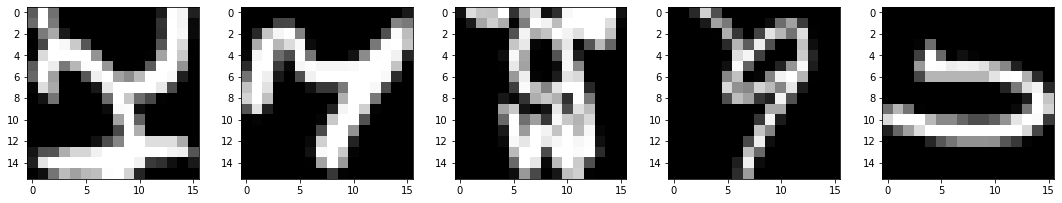

In [282]:
#get the top 5 samples with highest error rates
idx = np.argsort(errors)[::-1][:5]
visualize(X, y, idx)

## Gaussian Kernel

In [244]:
#initialization
np.random.seed(4)
train_split = 0.8
c_list = [0.001, 0.005, 0.010, 0.015, 0.020, 0.050, 0.100]
train_error, train_std, test_error, test_std = [], [], [], []

for c in c_list:               #for different dimensions of the polynomial kernel
    single_run_train_errors, single_run_test_errors = [], []
    for run in tqdm(range(20)):      #perform 20 runs
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, shuffle=True)     #randomly split the data
        clf = MultiKernelPerceptron(X_train, y_train, X_test, y_test, kernel='g', kernel_param=c, epochs=5)
        train_e = clf.train()                            #compute the training error on the 80% data
        single_run_train_errors.append(train_e)
        test_e = clf.test()                              #compute the test error on the 20% data
        single_run_test_errors.append(test_e) 
    train_error.append(np.mean(single_run_train_errors))
    train_std.append(np.std(single_run_train_errors))
    test_error.append(np.mean(single_run_test_errors))
    test_std.append(np.std(single_run_test_errors))
    print('Gaussian kernel width: ', c, ', mean train error: ', train_error[-1], ', mean test error: ', test_error[-1])

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Gaussian kernel width:  0.001 , mean train error:  7.342027426727614 , mean test error:  8.71236559139785


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Gaussian kernel width:  0.005 , mean train error:  1.1689970422156493 , mean test error:  4.029569892473118


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Gaussian kernel width:  0.01 , mean train error:  0.4228287173971498 , mean test error:  3.354838709677419


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Gaussian kernel width:  0.015 , mean train error:  0.20838935197633773 , mean test error:  3.088709677419355


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Gaussian kernel width:  0.02 , mean train error:  0.15595590212422694 , mean test error:  3.010752688172043


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Gaussian kernel width:  0.05 , mean train error:  0.04705566012368917 , mean test error:  3.8844086021505384


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]

Gaussian kernel width:  0.1 , mean train error:  0.025544501210002696 , mean test error:  4.873655913978494


In [245]:
#tabulate the results
data = []
for i in range(len(c_list)):
    train_result = f"{'{:.4f}'.format(train_error[i])}±{'{:.4f}'.format(train_std[i])}"
    test_result = f"{'{:.4f}'.format(test_error[i])}±{'{:.4f}'.format(test_std[i])}"
    result = [c_list[i], train_result, test_result]
    data.append(result)
print(tabulate(data, 
               headers = ["c", "Mean Train Error Rates (%)", "Mean Test Error Rates (%)"], 
               tablefmt = "simple_outline",
               stralign = "center"))

┌───────┬──────────────────────────────┬─────────────────────────────┐
│     c │  Mean Train Error Rates (%)  │  Mean Test Error Rates (%)  │
├───────┼──────────────────────────────┼─────────────────────────────┤
│ 0.001 │        7.3420±0.3039         │        8.7124±1.9736        │
│ 0.005 │        1.1690±0.1853         │        4.0296±0.5973        │
│ 0.01  │        0.4228±0.1045         │        3.3548±0.5175        │
│ 0.015 │        0.2084±0.0547         │        3.0887±0.5244        │
│ 0.02  │        0.1560±0.0694         │        3.0108±0.3666        │
│ 0.05  │        0.0471±0.0277         │        3.8844±0.3728        │
│ 0.1   │        0.0255±0.0175         │        4.8737±0.5252        │
└───────┴──────────────────────────────┴─────────────────────────────┘


In [238]:
#initialization 
np.random.seed(1)
train_split = 0.8
c_stars, test_errors = [], []
c_list = [0.001, 0.005, 0.010, 0.015, 0.020, 0.050, 0.100]

for run in tqdm(range(20)):          #perform 20 runs
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, shuffle=True)     #randomly split the data
    c_star, best_error = 0, float('inf')            #initialize the best d and best error
    for c in c_list:           #try different dimensions of the polynomial kernel
        valid_errors = []      #initialize a list to store validation errors
        X_train_frold, X_valid_fold, y_train_fold, y_valid_fold = KFold(X_train, y_train, 5)    #split the training set into 5 folds
        for Xtrain, Xvalid, ytrain, yvalid in zip(X_train_frold, X_valid_fold, y_train_fold, y_valid_fold):
            clf = MultiKernelPerceptron(Xtrain, ytrain, Xvalid, yvalid, kernel='g', kernel_param=c, epochs=5)
            train_error = clf.train()               #train the classifier
            valid_errors.append(clf.test())         #evalaute the classifier on the validation set
        if np.mean(valid_errors) < best_error:      #if the current c value gives a lower error rate
            best_error = np.mean(valid_errors)      #update the best error so far
            c_star = c                              #update the best c value so far
    #retrain the classifier on the entire training set with the best c value
    clf = MultiKernelPerceptron(X_train, y_train, X_test, y_test, kernel='g', kernel_param=c_star, epochs=5)   
    train_error = clf.train()
    test_error = clf.test()
    test_errors.append(test_error)
    c_stars.append(c_star)
    print('c*: ', c_star, ', test error rate: ', test_errors[-1])

  5%|████                                                                              | 1/20 [01:48<34:17, 108.29s/it]

c*:  0.01 , test error rate:  2.903225806451613


 10%|████████▏                                                                         | 2/20 [04:09<38:21, 127.86s/it]

c*:  0.015 , test error rate:  3.064516129032258


 15%|████████████▎                                                                     | 3/20 [06:22<36:47, 129.87s/it]

c*:  0.02 , test error rate:  3.2795698924731185


 20%|████████████████▍                                                                 | 4/20 [08:46<36:10, 135.64s/it]

c*:  0.02 , test error rate:  2.5268817204301075


 25%|████████████████████▌                                                             | 5/20 [11:07<34:21, 137.46s/it]

c*:  0.015 , test error rate:  2.795698924731183


 30%|████████████████████████▌                                                         | 6/20 [12:52<29:28, 126.35s/it]

c*:  0.02 , test error rate:  3.387096774193549


 35%|████████████████████████████▋                                                     | 7/20 [14:36<25:47, 119.07s/it]

c*:  0.01 , test error rate:  3.4408602150537635


 40%|████████████████████████████████▊                                                 | 8/20 [16:15<22:32, 112.68s/it]

c*:  0.015 , test error rate:  2.795698924731183


 45%|████████████████████████████████████▉                                             | 9/20 [18:13<20:58, 114.43s/it]

c*:  0.02 , test error rate:  3.010752688172043


 50%|████████████████████████████████████████▌                                        | 10/20 [20:10<19:13, 115.40s/it]

c*:  0.015 , test error rate:  2.795698924731183


 55%|████████████████████████████████████████████▌                                    | 11/20 [22:18<17:51, 119.10s/it]

c*:  0.01 , test error rate:  2.956989247311828


 60%|████████████████████████████████████████████████▌                                | 12/20 [24:13<15:42, 117.86s/it]

c*:  0.01 , test error rate:  3.2795698924731185


 65%|████████████████████████████████████████████████████▋                            | 13/20 [26:18<14:01, 120.17s/it]

c*:  0.015 , test error rate:  3.2795698924731185


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [28:22<12:06, 121.07s/it]

c*:  0.02 , test error rate:  3.3333333333333335


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [32:14<12:52, 154.51s/it]

c*:  0.02 , test error rate:  3.1720430107526885


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [35:46<11:27, 171.91s/it]

c*:  0.015 , test error rate:  3.4408602150537635


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [39:09<09:03, 181.28s/it]

c*:  0.015 , test error rate:  2.741935483870968


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [40:37<05:06, 153.18s/it]

c*:  0.015 , test error rate:  2.903225806451613


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [42:05<02:13, 133.56s/it]

c*:  0.015 , test error rate:  3.2795698924731185


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [44:10<00:00, 132.53s/it]

c*:  0.015 , test error rate:  2.6344086021505375


In [239]:
#tabulate the results
data = []
for i in range(20):
    test_result = f"{'{:.4f}'.format(test_errors[i])}"
    result = [int(i+1), c_stars[i], test_result]
    data.append(result)
print(tabulate(data, 
               headers = ["run", "c*", "Test Error Rates (%)"], 
               tablefmt = "simple_outline",
               numalign = "center"))

┌───────┬───────┬─────────────────────────────┐
│  run  │  c*   │  Mean Test Error Rates (%)  │
├───────┼───────┼─────────────────────────────┤
│   1   │ 0.01  │           2.9032            │
│   2   │ 0.015 │           3.0645            │
│   3   │ 0.02  │           3.2796            │
│   4   │ 0.02  │           2.5269            │
│   5   │ 0.015 │           2.7957            │
│   6   │ 0.02  │           3.3871            │
│   7   │ 0.01  │           3.4409            │
│   8   │ 0.015 │           2.7957            │
│   9   │ 0.02  │           3.0108            │
│  10   │ 0.015 │           2.7957            │
│  11   │ 0.01  │            2.957            │
│  12   │ 0.01  │           3.2796            │
│  13   │ 0.015 │           3.2796            │
│  14   │ 0.02  │           3.3333            │
│  15   │ 0.02  │            3.172            │
│  16   │ 0.015 │           3.4409            │
│  17   │ 0.015 │           2.7419            │
│  18   │ 0.015 │           2.9032      

In [243]:
print('Mean c*: ', f"{'{:.4f}'.format(np.mean(c_stars))} ± {'{:.4f}'.format(np.std(c_stars))}")
print('Mean Test Error (%): ', f"{'{:.4f}'.format(np.mean(test_errors))} ± {'{:.4f}'.format(np.std(test_errors))}")

Mean c*:  0.0155 ± 0.0035
Mean Test Error (%):  3.0511 ± 0.2751
